# Object-oriented-programmed Neural Network

### Multiclass classification with softmax

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We define several classes :
- a "net" class that will be instantiated only once
- several "layer" classes, which will have to be instantiated Keras-style.

Examples are vertical vectors, so the matrix Y representing the labels is of shape ```(number_of_classes, number_of_examples)```

In [2]:
def to_one_hot(M1):
    n_classes = 3
    M2 = np.zeros((n_classes, sample_size * 3))
    for i in range(n_classes * 3):
        M2[M1[i], i] = 1

def from_one_hot(M1):
    decoded = np.argmax(M1, axis=0)
    assert decoded.shape[1] == M1.shape[1]
    return decoded

In [3]:
class Net():
    
    def __init__(self, loss_type):
        self.layers = []
        self.loss_type = loss_type
        
    def add(self, layer):
        self.layers.append(layer)
        
    def forward_pass(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A

    def MCE1(self, preds, labels):
        # preds: probabilities in a (nclasses, nexamples) array
        # labels: 1-0 in a (nclasses, nexamples) array (one-hot encoded)
        assert preds.shape == labels.shape
        cross = np.multiply(preds, labels)
        cross = cross[cross != 0]
        cross = -np.log(cross)
        cross = np.mean(cross)
        return cross

    def MCE2(self, A, Y):
        nb_examples = A.shape[1]
        assert A.shape == Y.shape
        temp = np.multiply(A,Y)
        temp = np.sum(temp, axis=0, keepdims=True)
        temp = - np.log(temp)
        loss = 1 / nb_examples * np.sum(temp, axis=None)
        return loss
    
    def backward_pass(self, dERROR, learning_rate):
        backward_list = reversed(self.layers[0:-1])
        for layer in backward_list:
            dERROR = layer.backward(dERROR, learning_rate)

    def train(self, X, Y, learning_rate, epochs, prints_freq=0, plot=False):
        costs1 = []
        costs2 = []
        for epoch in range(epochs):
            A = self.forward_pass(X)
            dERROR = A - Y # at this point dERROR = dJ/dZ
            curr_cross_entropy1 = self.MCE1(A, Y)
            curr_cross_entropy2 = self.MCE2(A, Y)
            costs1.append(curr_cross_entropy1)
            costs2.append(curr_cross_entropy2)
            
            if prints_freq > 0:
                if epoch % prints_freq == 0:
                    print("Epoch:", epoch, "  Cost:", curr_cross_entropy)
                
            self.backward_pass(dERROR, learning_rate)
        
        if plot:
            plt.plot(costs1)
            plt.plot(costs2)
        
    def get_accuracy(self, A, Y):
        # get best-guess predictions
        preds = np.argmax(A, axis=0)
        flattened_Y = np.argmax(Y, axis=0)
        # check how many such guesses were right
        correct_preds = (flattened_Y == preds)
        n_correct = np.sum(correct_preds)
        # get accuracy rate
        m = A.shape[1] # number of examples
        accuracy = n_correct / m
        return accuracy

In [4]:
class LayerFC():    
    def __init__(self, n_x, n_h):
        self.W = np.random.randn(n_h, n_x)
        self.b = np.zeros((n_h, 1))
    def forward(self, A_prev):
        assert A_prev.shape[0] == self.W.shape[1]
        assert self.b.shape[0] == self.W.shape[0]
        self.A_prev = A_prev
        self.Z = np.dot(self.W, self.A_prev) + self.b
        return self.Z
    def backward(self, dERROR, learning_rate):
        m = dERROR.shape[1] #batch size
        dW = (1 / m) * np.dot(dERROR, self.A_prev.T)
        db = (1 / m) * np.sum(dERROR, axis=1, keepdims=True)
        assert self.W.shape[0] == dERROR.shape[0]        
        dERROR = np.dot(self.W.T, dERROR)
        self.W = self.W - learning_rate * dW        
        self.b = self.b - learning_rate * db                
        return dERROR
    
class LayerSigmoid():
    def forward(self, Z):
        self.A = 1 / (1 + np.exp(-Z))
        return self.A
    def backward(self, dERROR, learning_rate):
        derivative = self.A * (1 - self.A)
        assert derivative.shape == dERROR.shape
        dERROR = dERROR * derivative        
        return dERROR

class LayerTanh():    
    def forward(self, Z):
        self.A = np.tanh(Z)
        return self.A
    def backward(self, dERROR, learning_rate):
        derivative = 1 - np.square(self.A)
        assert derivative.shape == dERROR.shape
        dERROR = dERROR * derivative
        return dERROR

class LayerSoftmax():    
    def forward(self, Z):
        self.t = np.exp(Z)
        exps_sum = np.sum(self.t)
        self.A = self.t / exps_sum
        return self.A


#### Generating examples

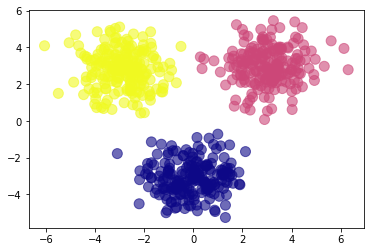

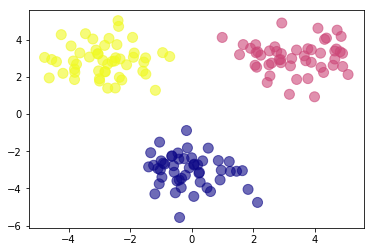

In [5]:
def gen_3plasma_zones(sample_size, show_dist=False):
    typeA = np.random.randn(sample_size, 2) + np.array([0, -3])
    typeB = np.random.randn(sample_size, 2) + np.array([3, 3])
    typeC = np.random.randn(sample_size, 2) + np.array([-3, 3])
    X = np.vstack([typeA, typeB, typeC]).T 
    
    Y_temp = np.array([0]*sample_size + [1]*sample_size + [2]*sample_size)
    Y = np.zeros((3, sample_size * 3))
    for i in range(sample_size * 3):
        Y[Y_temp[i], i] = 1

    if show_dist:
        plt.scatter(X[0, :], X[1, :], c=Y_temp, cmap='plasma', s=100, alpha=0.6)  
        plt.show()
    
    return X, Y, Y_temp

X_train_multi, Y_train_multi, _ = gen_3plasma_zones(200, True)
X_test_multi, Y_test_multi, _ = gen_3plasma_zones(50, True)

#### Training

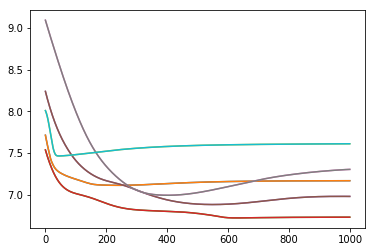

In [9]:
for i in range(5):
    net = Net('multi_cross_entropy')
    net.add(LayerFC(2,2))
    net.add(LayerTanh())
    net.add(LayerFC(2, 3))
    net.add(LayerTanh())
    net.add(LayerFC(3, 3))
    net.add(LayerTanh())
    net.add(LayerFC(3, 3))
    net.add(LayerSoftmax())

    net.train(X_train_multi, Y_train_multi, epochs=1000, learning_rate=0.01, prints_freq=0, plot=True)

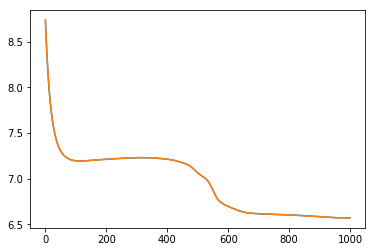

In [12]:
net = Net('multi_cross_entropy')
net.add(LayerFC(2,2))
net.add(LayerTanh())
net.add(LayerFC(2, 3))
net.add(LayerTanh())
net.add(LayerFC(3, 3))
net.add(LayerTanh())
net.add(LayerFC(3, 3))
net.add(LayerSoftmax())

net.train(X_train_multi, Y_train_multi, epochs=1000, learning_rate=0.01, prints_freq=0, plot=True)

In [13]:
r = net.forward_pass(X_test_multi)
net.get_accuracy(r, Y_test_multi)

1.0

#### Conclusion
A very weird result: a crappy cost, but OK accuracy on test set...